In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve

from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import KFold


In [2]:
# Load the dataset
path = '/Users/tomcio/Documents/GitHub/MIT_MBAn_NER/data/'
df = pd.read_csv(path + 'training_data_RAW.csv')

In [5]:
# Split data into training, testing, and validation sets
X_train, X_remain, y_train, y_remain = train_test_split(df['Name'], df['label'], test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_remain, y_remain, test_size=0.5, random_state=42)

# Character-level vectorization
vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 5))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_val_vec = vectorizer.transform(X_val)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_vec_smote, y_train_smote = smote.fit_resample(X_train_vec, y_train)

In [9]:
# Train models (with the SMOTE-balanced dataset)
model_nb = MultinomialNB()
model_nb.fit(X_train_vec_smote, y_train_smote) 

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_vec_smote, y_train_smote) 

model_lr = LogisticRegression(solver='lbfgs', max_iter=500) 
model_lr.fit(X_train_vec_smote, y_train_smote) 

LogisticRegression(max_iter=500)

In [11]:
# Function for predictions
def predict_drug_probability(new_word, model):
    new_word_vec = vectorizer.transform([new_word.lower()])
    probability = model.predict_proba(new_word_vec)[0][1]
    return probability

# Function for predictions at varying thresholds
def get_predictions_at_thresholds(model, X_val_vec, thresholds):
    probabilities = model.predict_proba(X_val_vec)[:, 1]
    results = []
    for threshold in thresholds:
        predictions = [1 if prob >= threshold else 0 for prob in probabilities]
        results.append((threshold, predictions))
    return results

# Example thresholds for testing
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]


## The F1 score is calculated as the harmonic mean of the precision and recall scores

In [21]:
def evaluate_model_with_thresholds(model, X_val, y_val, thresholds):
    results = get_predictions_at_thresholds(model, X_val, thresholds)
    best_f1 = 0
    optimal_metrics = {
        'threshold': None,
        'precision': None,
        'recall': None,
        'accuracy': None,
        'f1': None
    }

    for threshold, predictions in results:
        precision = precision_score(y_val, predictions)
        recall = recall_score(y_val, predictions)
        accuracy = accuracy_score(y_val, predictions)
        f1 = f1_score(y_val, predictions)

        if f1 > best_f1:
            best_f1 = f1
            optimal_metrics.update({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'accuracy': accuracy,
                'f1': f1
            })

    return optimal_metrics

# Naive Bayes Evaluation
optimal_nb = evaluate_model_with_thresholds(model_nb, X_val_vec, y_val, thresholds)
print(f"\n--- Optimal Naive Bayes Threshold ---")
print(f"Threshold: {optimal_nb['threshold']:.2f}, Precision: {optimal_nb['precision']:.2f}, Recall: {optimal_nb['recall']:.2f}, Accuracy: {optimal_nb['accuracy']:.2f}, Best F1-Score: {optimal_nb['f1']:.2f}")

# Random Forest Evaluation
optimal_rf = evaluate_model_with_thresholds(model_rf, X_val_vec, y_val, thresholds)
print(f"\n--- Optimal Random Forest Threshold ---")
print(f"Threshold: {optimal_rf['threshold']:.2f}, Precision: {optimal_rf['precision']:.2f}, Recall: {optimal_rf['recall']:.2f}, Accuracy: {optimal_rf['accuracy']:.2f}, Best F1-Score: {optimal_rf['f1']:.2f}")

# Logistic Regression Evaluation
optimal_lr = evaluate_model_with_thresholds(model_lr, X_val_vec, y_val, thresholds)
print(f"\n--- Optimal Logistic Regression Threshold ---")
print(f"Threshold: {optimal_lr['threshold']:.2f}, Precision: {optimal_lr['precision']:.2f}, Recall: {optimal_lr['recall']:.2f}, Accuracy: {optimal_lr['accuracy']:.2f}, Best F1-Score: {optimal_lr['f1']:.2f}")



--- Optimal Naive Bayes Threshold ---
Threshold: 0.90, Precision: 0.65, Recall: 0.79, Accuracy: 0.93, Best F1-Score: 0.71

--- Optimal Random Forest Threshold ---
Threshold: 0.45, Precision: 0.66, Recall: 0.83, Accuracy: 0.94, Best F1-Score: 0.73

--- Optimal Logistic Regression Threshold ---
Threshold: 0.70, Precision: 0.79, Recall: 0.69, Accuracy: 0.95, Best F1-Score: 0.74


### ROC-AUC Curves:


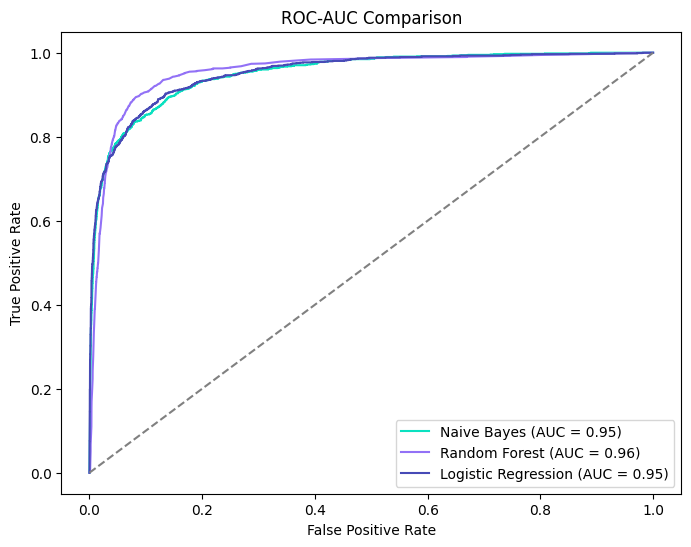

In [54]:
# Calculate ROC-AUC for each model
nb_roc_auc = roc_auc_score(y_val, model_nb.predict_proba(X_val_vec)[:, 1])
rf_roc_auc = roc_auc_score(y_val, model_rf.predict_proba(X_val_vec)[:, 1])
lr_roc_auc = roc_auc_score(y_val, model_lr.predict_proba(X_val_vec)[:, 1])

# Calculate False Positive Rate (FPR), True Positive Rate (TPR)
fpr_nb, tpr_nb, _ = roc_curve(y_val, model_nb.predict_proba(X_val_vec)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_val, model_rf.predict_proba(X_val_vec)[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_val, model_lr.predict_proba(X_val_vec)[:, 1])

teal_color = "#0AE1C0"
purple_color = "#9271F6"
dark_blue_color = "#474AB6"

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {nb_roc_auc:.2f})', color=teal_color)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.2f})', color=purple_color)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_roc_auc:.2f})', color=dark_blue_color)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Comparison')
plt.legend()
plt.show()

### Precision-Recall Curves



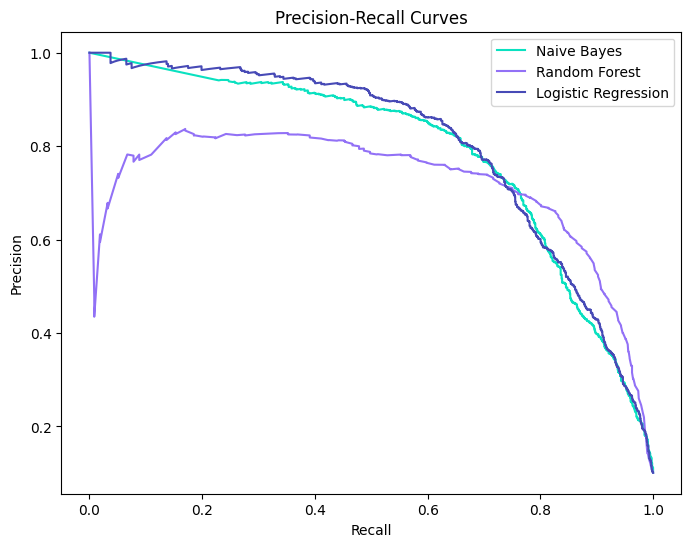

In [50]:
# Calculate precision & recall for each model
nb_precision, nb_recall, _ = precision_recall_curve(y_val, model_nb.predict_proba(X_val_vec)[:, 1])
rf_precision, rf_recall, _ = precision_recall_curve(y_val, model_rf.predict_proba(X_val_vec)[:, 1])
lr_precision, lr_recall, _ = precision_recall_curve(y_val, model_lr.predict_proba(X_val_vec)[:, 1])

# Replace these with the actual hexadecimal color codes from your slides
teal_color = "#0AE1C0"
purple_color = "#9271F6"  # e.g., "#800080"
dark_blue_color = "#474AB6"  # e.g., "#000080"

# The rest of your code for plotting goes here
plt.figure(figsize=(8, 6))
plt.plot(nb_recall, nb_precision, label='Naive Bayes', color=teal_color)
plt.plot(rf_recall, rf_precision, label='Random Forest', color=purple_color)
plt.plot(lr_recall, lr_precision, label='Logistic Regression', color=dark_blue_color)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

### Bar Chart Accuracy and F1-Score Comparison



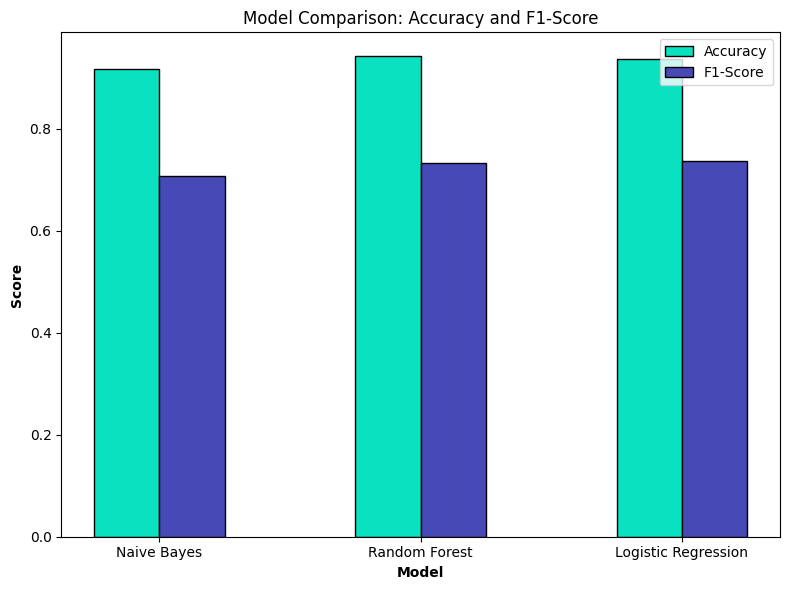

In [53]:

# Naive Bayes 
nb_val_preds = model_nb.predict(X_val_vec) 
nb_accuracy = accuracy_score(y_val, nb_val_preds)
nb_results = get_predictions_at_thresholds(model_nb, X_val_vec, thresholds)  # Assuming you have this function defined 
best_f1_nb = 0
for _, preds in nb_results:
    f1 = f1_score(y_val, preds)
    if f1 > best_f1_nb:
        best_f1_nb = f1

# Random Forest
rf_val_preds = model_rf.predict(X_val_vec)
rf_accuracy = accuracy_score(y_val, rf_val_preds)
rf_results = get_predictions_at_thresholds(model_rf, X_val_vec, thresholds) 
best_f1_rf = 0
for _, preds in rf_results:
    f1 = f1_score(y_val, preds)
    if f1 > best_f1_rf:
        best_f1_rf = f1

# Logistic Regression
lr_val_preds = model_lr.predict(X_val_vec)
lr_accuracy = accuracy_score(y_val, lr_val_preds)
lr_results = get_predictions_at_thresholds(model_lr, X_val_vec, thresholds) 
best_f1_lr = 0
for _, preds in lr_results:
    f1 = f1_score(y_val, preds)
    if f1 > best_f1_lr:
        best_f1_lr = f1

# Model names
models = ['Naive Bayes', 'Random Forest', 'Logistic Regression']

# Accuracy and F1-Score for each model
accuracy_scores = [nb_accuracy, rf_accuracy, lr_accuracy]
f1_scores = [best_f1_nb, best_f1_rf, best_f1_lr]

# Set the position of bar on X axis
r1 = np.arange(len(accuracy_scores))
r2 = [x + 0.25 for x in r1]

teal_color = "#0AE1C0"
purple_color = "#9271F6"  # e.g., "#800080"
dark_blue_color = "#474AB6"  # e.g., "#000080"

# Make the plot
plt.figure(figsize=(8, 6))  # Adjusted figure size to match your preferred style
plt.bar(r1, accuracy_scores, color=teal_color, width=0.25, edgecolor='black', label='Accuracy')
plt.bar(r2, f1_scores, color=dark_blue_color, width=0.25, edgecolor='black', label='F1-Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + 0.125 for r in range(len(accuracy_scores))], models)
plt.ylabel('Score', fontweight='bold')
plt.title('Model Comparison: Accuracy and F1-Score')

# Create legend & Show graphic
plt.legend()
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


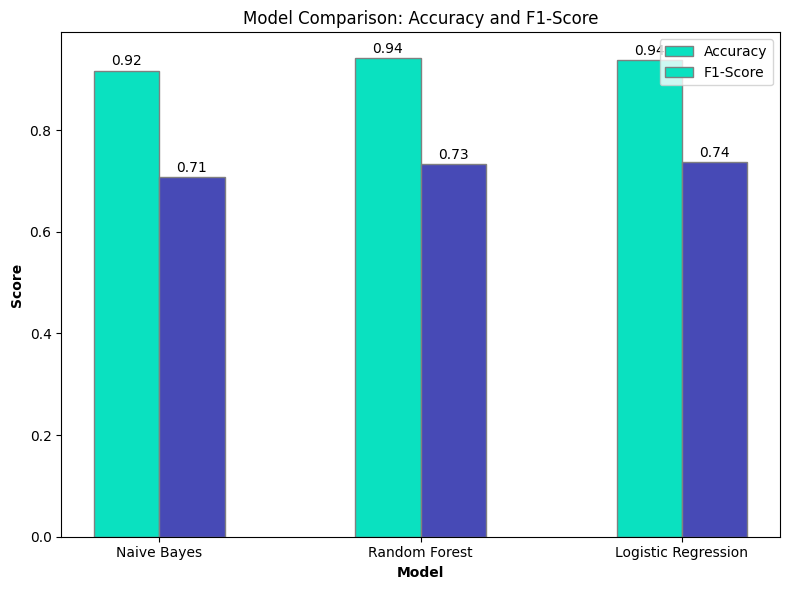

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the rest of your code is defined above this point

# Make the plot
plt.figure(figsize=(8, 6))  # Adjusted figure size for clarity
bar_width = 0.25  # Width of the bars

# Plot accuracy bars
for i in range(len(accuracy_scores)):
    plt.bar(r1[i], accuracy_scores[i], color=teal_color, width=bar_width, edgecolor='grey')
    # Add value labels above the bars
    plt.text(r1[i], accuracy_scores[i] + 0.01, f'{accuracy_scores[i]:.2f}', ha='center')

# Plot F1-score bars
for i in range(len(f1_scores)):
    plt.bar(r2[i], f1_scores[i], color=dark_blue_color, width=bar_width, edgecolor='grey')
    # Add value labels above the bars
    plt.text(r2[i], f1_scores[i] + 0.01, f'{f1_scores[i]:.2f}', ha='center')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(accuracy_scores))], models)
plt.ylabel('Score', fontweight='bold')
plt.title('Model Comparison: Accuracy and F1-Score')

# Create legend & Show graphic
plt.legend(['Accuracy', 'F1-Score'])
plt.tight_layout()  # Adjust layout to not cut off labels

# Adjust y-axis limit to create space above bars
plt.ylim(0, max(max(accuracy_scores), max(f1_scores)) + 0.05)  # Slightly less space than before

plt.show()
